### Problem1: why hdf files are not being converted to shapefile  
- verdict: there was not hdf file because coverage string with tabs in function was not being understood by server

In [1]:
%matplotlib inline

In [2]:
import os

import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.figsize': (15, 8), 'font.size': 10})

from shapely.geometry import Polygon, Point

In [3]:
from icesat2_search_and_download_ATL import gps2dyr

In [4]:
import h5py

In [5]:
region = 'region_31_alaska_south'#'region_19_victoria_land' #'region_03_peninsula_south'
# folder = f'W:/icesat2/rema/{region}'
folder = f'D:/icesat2/EarthDEM/{region}'
strips = os.listdir(folder)
strips

['WV03_20190510_104001004C16DA00_104001004B1BE800_2m_lsf',
 'WV03_20190512_104001004CA26100_104001004C5F0C00_2m_lsf',
 'WV03_20190611_104001004D1EFD00_104001004DD70D00_2m_lsf',
 'WV03_20190623_104001004E1FA800_104001004F3C6800_2m_lsf',
 'WV03_20190701_104001004DAB5A00_104001004D7E5D00_2m_lsf',
 'WV03_20190705_104001004D7DD600_104001004D7D0500_2m_lsf',
 'WV03_20190705_104001004E70E200_104001004D3F5400_2m_lsf',
 'WV03_20190706_104001004F170D00_104001004D479D00_2m_lsf']

In [6]:
strip = strips[1]
os.listdir(f'{folder}/{strip}')

['processed_ATL08_20190522022257_08220306_002_01.cpg',
 'processed_ATL08_20190522022257_08220306_002_01.csv',
 'processed_ATL08_20190522022257_08220306_002_01.dbf',
 'processed_ATL08_20190522022257_08220306_002_01.h5',
 'processed_ATL08_20190522022257_08220306_002_01.prj',
 'processed_ATL08_20190522022257_08220306_002_01.shp',
 'processed_ATL08_20190522022257_08220306_002_01.shx',
 'strip_outline.cpg',
 'strip_outline.dbf',
 'strip_outline.prj',
 'strip_outline.shp',
 'strip_outline.shx']

In [7]:
icesat2_path = f'{folder}/{strip}'

---

In [6]:

# icesat2_path = 'D:/wspace/icesat2/alaska'
icesat2_path = f'/fs/project/howat.4/yadav.111/icesat2/greenland'


In [13]:
# os.listdir(icesat2_path)

In [8]:
# outline = gpd.read_file(f'{icesat2_path}/strip_outline.shp')
outline = gpd.read_file(f'{icesat2_path}/outline.shp')
outline

,FID,geometry
0,0,"POLYGON ((-73.23858 78.62993, -73.23763 78.631..."


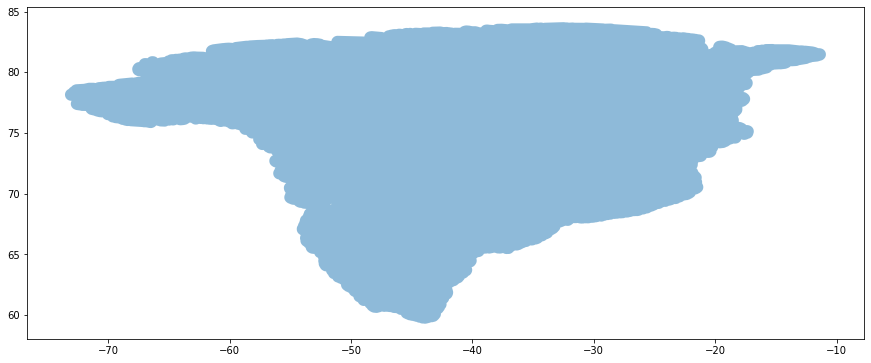

In [9]:
# outline.plot(column='seg_id', alpha=.5);
outline.plot(alpha=.5)

In [10]:
outline.area

0    790.104322
dtype: float64

In [11]:
# def read_atl06(icesat2_path):
""" 
Read 1 ATL06 file and output 6 reduced files. 

Extract variables of interest and separate the ATL06 file 
into each beam (ground track) and ascending/descending orbits.
"""
files = os.listdir(f'{icesat2_path}')
# files
hdf_files = [f for f in files if f.endswith('.h5')]
print(hdf_files)

In [14]:
# for f in hdf_files[5:6]:
f = hdf_files[1]
hdf_path = f'{icesat2_path}/{f}'
print(f'{hdf_path} {os.path.exists(hdf_path)}')
res_dict = {}
meta_dict = {} #These will hold metadata required for scalars per ground-track
# group = ['gt1l', 'gt1r', 'gt2l', 'gt2r', 'gt3l', 'gt3r']
# group = ['gt2l', 'gt2r', 'gt3l', 'gt3r']
# group = ['gt1l', 'gt1r']
group = ['gt1l', 'gt1r', 'gt2l', 'gt2r', 'gt3l', 'gt3r']
# Loop trough beams
# Perhaps read file first, then loop through groups; should be faster


In [ ]:
        qual_str_count = ''
        # Loop trough beams
        # Perhaps read file first, then loop through groups; should be faster
        with h5py.File(hdf_path, 'r') as fi:
            # subset group based on data
            group = [g for g in list(fi.keys()) if g in group]
            for k,g in enumerate(group):
                try:
                    # 1) Read in data for a single beam #
                    lat = fi[f'/{g}/land_ice_segments/latitude'][:]
                    lon = fi[f'/{g}/land_ice_segments/longitude'][:]
                    h_li = fi[f'/{g}/land_ice_segments/h_li'][:] #nan
                    #s_li = fi[f'/{g}/land_ice_segments/h_li_sigma'][:] #nan
                    t_dt = fi[f'/{g}/land_ice_segments/delta_time'][:]
                    q_flag = fi[f'/{g}/land_ice_segments/atl06_quality_summary'][:]
                    t_ref = fi['/ancillary_data/atlas_sdp_gps_epoch'][:] #scalar 1 value; required for offset
                    #rgt = fi['/orbit_info/rgt'][:] * np.ones(len(lat)) #scalar 1 value
                    #orb = np.full_like(h_li, k) #scalar 1 value
                    
                    meta_dict['t_ref'] = t_ref #dictionary of metadata (will be used in future to investigate data)
                    # 2) Make Pandas dataframe
                    #t_dt = gps2dyr(t_dt, offset=t_ref) #time consuming 
                    df = pd.DataFrame({'lon':lon, 'lat':lat, 'h_li': h_li, 'q_flag':q_flag, 't_dt':t_dt})
                    #Convert GPS time to actual time using function
                    df['t_dt'] = df['t_dt'].apply(gps2dyr, offset=t_ref[0])
                    #df['fname'] = f.split('.')[0] #to save hdf filename; could important when multiple hdf files over a rema tile
                    #df.index = df.t_dt #creates difficultly in plotting
                    # Fill Nans for na-data and drop
                    df.loc[df.h_li>3e38, 'h_li'] = np.nan
                    df = df.dropna()
                    all_points = len(df)
                    #df = df[df.q_flag==0] #select only flags of zero (good values) can be empty sometimes
                    good_quality_points = len(df) #len(df[df.q_flag==0])
                    qual_str_count = qual_str_count + f'{g}={good_quality_points}/{all_points}; '
                    if len(df)>0:
                        # Assemble ground track into a dictionary, later we convert to csv and shp through df
                        res_dict[g] = df
                except:
                    # Most like this error is due to empty dataframe 
                    # may not exist anymore since we are no dropping the bad quality data
                    logging.error(f'\tException in reading hdf group (ground track), df length = {len(df)}')
            #----------------------------------------------------------------------------------------------
            # Now that ATL06 data from separate ground tracks are in one dict, merge it to df and save to csv/shp
            if len(res_dict)>0:
                logging.info(f'\tGood/Total Points: {qual_str_count}   Total GTs = {len(res_dict)}')
                # To guard againt empty result dictionary created with no icesat2 passing the quality control above
                # 1. Combine Dataframes for each of 6 ground-tracks into single Dataframe
                count = 0
                for k in res_dict.keys():
                    # k = 'gt1l', 'gt1r' etc
                    if count == 0:
                        df = res_dict[k]
                        df['strip'] = k
                        count += 1
                    else:
                        df1 = res_dict[k]
                        df1['strip'] = k
                        df = pd.concat([df, df1], axis=0)
                # Log the time range of icesat2 data (could be useful for understanding why some data is large)
                # This may be creating exception when empty
                time_range = df.t_dt.max() - df.t_dt.min()
                logging.info(f"\tRows = {len(df)} \t Time Range = {time_range.total_seconds()} seconds")
                # Choose filename for csv and shapefile
                atl_fname = os.path.splitext(hdf_path)[0].split('/')[-1]
                #df = df[df.q_flag==0] # Already done above for each ground track
                df.to_csv(f'{icesat2_path}/{atl_fname}.csv', index=False)
                
                # 2. Convert to Geopandas
                df['coord'] = df[['lon', 'lat']].apply(lambda x: Point(x), axis=1)
                gdf = gpd.GeoDataFrame(df[['t_dt', 'h_li', 'q_flag', 'strip', 'coord']], geometry='coord')
                gdf['t_dt'] = gdf['t_dt'].dt.strftime('%Y-%m-%d %H:%M:%S.%f') #To prevent DriverSupportError: ESRI Shapefile does not support datetime fields
                gdf.crs = {'init': 'epsg:4326'} #not yet verified or checked with what ICESAT-2 metadata provides
                gdf.to_file(f'{icesat2_path}/{atl_fname}.shp')
                # perhaps even return df or gdf 
                return gdf
            else:
                logging.info(f"\tNo good quality Ground Track in this HDF file; csv or shp not created")
    # Perhaps merge if more than one hdf file present per tile (or write 2 separate functions)


In [14]:
with h5py.File(hdf_path, 'r') as fi:
    print(list(fi.keys()))
    group = [g for g in list(fi.keys()) if g in group]
    print(group)
    for k,g in enumerate(group):
        # 1) Read in data for a single beam #
        lat = fi[f'/{g}/land_segments/latitude'][:]
        lon = fi[f'/{g}/land_segments/longitude'][:]
        h_li = fi[f'/{g}/land_segments/terrain/h_te_mean'][:] #nan
        h_canopy = fi[f'/{g}/land_segments/canopy/h_canopy'][:] #nan
        #s_li = fi[f'/{g}/land_ice_segments/h_li_sigma'][:] #nan
        t_dt = fi[f'/{g}/land_segments/delta_time'][:]
        q_flag = fi[f'/{g}/land_segments/layer_flag'][:]
        t_ref = fi[f'/ancillary_data/atlas_sdp_gps_epoch'][:] #scalar 1 value
        #rgt = fi['/orbit_info/rgt'][:] * np.ones(len(lat)) #scalar 1 value
        #orb = np.full_like(h_li, k) #scalar 1 value

        meta_dict['t_ref'] = t_ref #dictionary of metadata (will be used in future to investigate data)
        # 2) Make Pandas dataframe
        #t_dt = gps2dyr(t_dt, offset=t_ref) #time consuming 
        df = pd.DataFrame({'lon':lon, 'lat':lat, 'h_li': h_li, 'h_canopy':h_canopy, 'q_flag':q_flag, 't_dt':t_dt})
        #Convert GPS time to actual time using function
        df['t_dt'] = df['t_dt'].apply(gps2dyr, offset=t_ref[0])
        #df.index = df.t_dt #creates difficultly in plotting
        #print(len(df))
        # Fill Nans for na-data
        df.loc[df.h_li>3e38, 'h_li'] = np.nan
        df.loc[df.h_canopy>3e38, 'h_canopy'] = np.nan
        df = df.dropna() #Drop these nans
        print(f'No of points in HDF file = {len(df)}')
        #df = df[df.q_flag==0] #select only flags of zero (good values) can be empty sometimes
        print(f'HDF points with good flag = {len(df)}')
        if len(df)>0:
            # 3) Put dataframe for each ground track into a dictionary
            res_dict[g] = df
print(f'Length of reslts dict: {len(res_dict)}')
print(f'Length of reslts dict: {len(res_dict)}')
if len(res_dict)>0:
    # To guard againt empty result dictionary created with no icesat2 passing the quality control above
    # 1. Combine Dataframes for each of 6 ground-tracks into single Dataframe
    count = 0
    for k in res_dict.keys():
        # k = 'gt1l', 'gt1r' etc
        if count == 0:
            df = res_dict[k]
            df['strip'] = k
            count += 1
        else:
            df1 = res_dict[k]
            df1['strip'] = k
            df = pd.concat([df, df1], axis=0)            
    # Use filename of ATL06 as shapefile
    atl_fname = os.path.splitext(hdf_path)[0].split('/')[-1] #fname.split('.h5')[0]
    # df.to_csv(f'D:/wspace/icesat2/saurab/rema1/csv/{atl_fname}.csv') # or not save it since big file
    #if len(df)>0:
    print(f'Total rows in Dataframe after combining all ground tracks = {len(df)}')
    #df.to_csv(f'{icesat2_path}/{atl_fname}.csv') # or not save it since big file

    # 2. Convert to Geopandas
    df['coord'] = df[['lon', 'lat']].apply(lambda x: Point(x), axis=1)
    gdf = gpd.GeoDataFrame(df[['h_li', 'h_canopy', 'strip', 'q_flag','coord']], geometry='coord')
    gdf.crs = {'init': 'epsg:4326'} #not yet verified or checked with what ICESAT-2 metadata provides

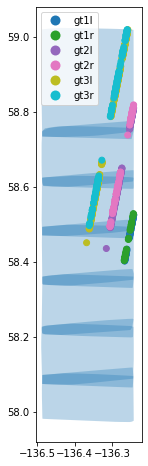

In [15]:
ax = outline.plot(alpha=.3)
gdf.plot(column='strip', legend=True, ax=ax);

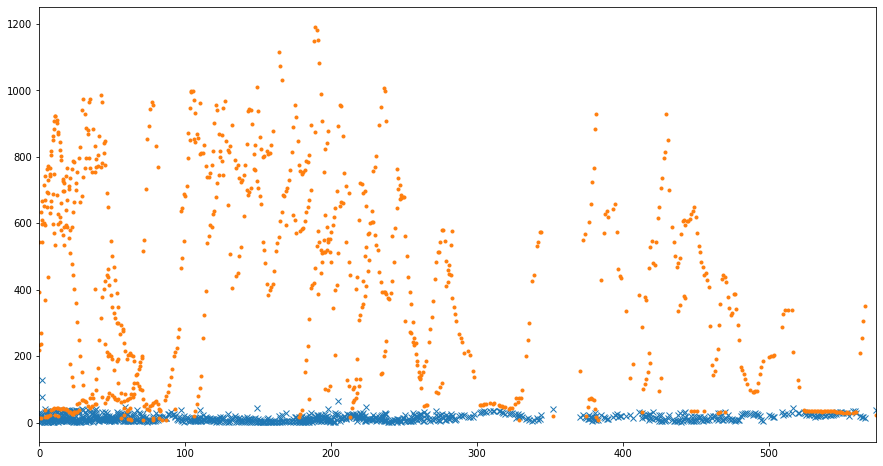

In [16]:
df.h_canopy.plot(style='x')
df.h_li.plot(style='.')

In [17]:
# gdf.q_flag.plot()
gdf.head(2)

,h_li,h_canopy,strip,q_flag,coord
0,13.293677,29.896385,gt1l,1,POINT (-136.24236 58.52649)
1,13.127890,27.753473,gt1l,0,POINT (-136.24254 58.52559)


In [18]:
import hvplot
import hvplot.pandas
import geoviews as gv

In [19]:
df.head(2)

,lon,lat,h_li,h_canopy,q_flag,t_dt,strip,coord
0,-136.242355,58.526485,13.293677,29.896385,1,2019-05-22 02:23:49.550,gt1l,POINT (-136.2423553466797 58.52648544311523)
1,-136.242538,58.525589,13.127890,27.753473,0,2019-05-22 02:23:49.564,gt1l,POINT (-136.2425384521484 58.52558898925781)


In [20]:
df.hvplot(y='h_canopy', x='t_dt', by='strip', kind='scatter')

:NdOverlay   [strip]
   :Scatter   [t_dt]   (h_canopy)

In [21]:
df.hvplot(y='h_li', x='t_dt', by='strip', kind='scatter')

:NdOverlay   [strip]
   :Scatter   [t_dt]   (h_li)

In [22]:
# gv.tile_sources.StamenTerrainRetina 
(gv.tile_sources.ESRI  * df.hvplot.points('lon', 'lat', geo=True, color='strip', alpha=0.6, width=500, height=800, hover=['strip', 'h_li']) + 
 df.hvplot(y='lat', x='h_canopy', by='q_flag', kind='scatter', height=800, alpha=.7)).cols(2)

:Layout
   .Overlay.I   :Overlay
      .WMTS.I   :WMTS   [Longitude,Latitude]
      .Points.I :Points   [lon,lat]   (strip)
   .NdOverlay.I :NdOverlay   [q_flag]
      :Scatter   [h_canopy]   (lat)

In [23]:
(gv.tile_sources.ESRI  * df.hvplot.points('lon', 'lat', geo=True, color='strip', alpha=0.6, width=500, height=800, hover=['strip', 'h_li']) + 
 df.hvplot(y='lat', x='h_li', by='q_flag', kind='scatter', height=800, alpha=.7)).cols(2)

:Layout
   .Overlay.I   :Overlay
      .WMTS.I   :WMTS   [Longitude,Latitude]
      .Points.I :Points   [lon,lat]   (strip)
   .NdOverlay.I :NdOverlay   [q_flag]
      :Scatter   [h_li]   (lat)

In [24]:
# outline.plot()

In [25]:
df.head()

,lon,lat,h_li,h_canopy,q_flag,t_dt,strip,coord
0,-136.242355,58.526485,13.293677,29.896385,1,2019-05-22 02:23:49.550,gt1l,POINT (-136.2423553466797 58.52648544311523)
1,-136.242538,58.525589,13.127890,27.753473,0,2019-05-22 02:23:49.564,gt1l,POINT (-136.2425384521484 58.52558898925781)
4,-136.243057,58.522907,18.209900,32.173889,1,2019-05-22 02:23:49.607,gt1l,POINT (-136.2430572509766 58.52290725708008)
5,-136.243240,58.522015,19.664680,33.568680,1,2019-05-22 02:23:49.621,gt1l,POINT (-136.2432403564453 58.52201461791992)
6,-136.243408,58.521118,19.194439,26.773607,1,2019-05-22 02:23:49.635,gt1l,POINT (-136.243408203125 58.5211181640625)


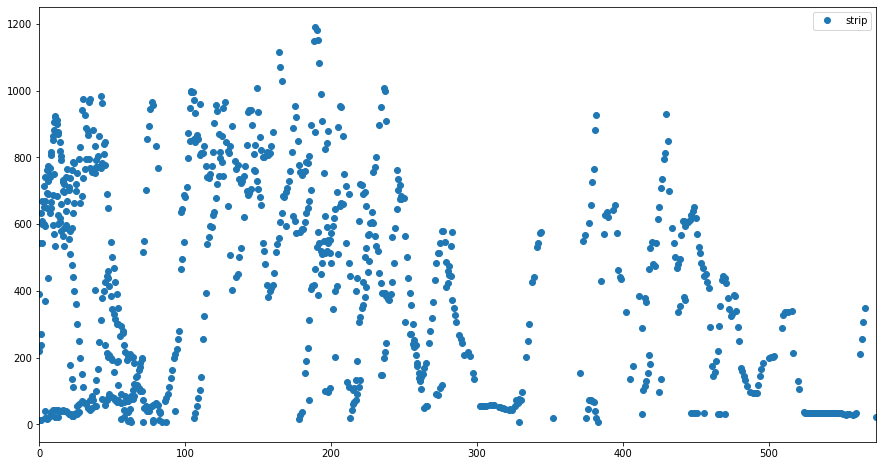

In [26]:
df.h_li.plot(style='o', label='strip')
plt.legend()

In [27]:
import holoviews as hv

In [28]:
points = hv.Points(np.random.randn(500,2))
points.hist(num_bins=51, dimension=['x','y'])

:AdjointLayout
   :Points   [x,y]
   :Histogram   [y]   (y_frequency)
   :Histogram   [x]   (x_frequency)

In [29]:
t_diff = df.t_dt.max() - df.t_dt.min()
t_diff

Timedelta('0 days 00:00:09.985000')

In [30]:
t_diff.total_seconds()/60

0.16641666666666666

In [31]:
# df.to_csv('C:/temp/del.csv', index=False)

In [32]:
import yaml

In [33]:
shp_files = [f for f in files if f.endswith('.shp') and 'ATL08' in f]
shp_files

['processed_ATL08_20190522022257_08220306_002_01.shp']

In [34]:
shp1 = f'{icesat2_path}/{shp_files[0]}'

In [35]:
gdf = gpd.read_file(shp1)

In [36]:
gdf['t_dt'] = pd.to_datetime(gdf.t_dt)

In [37]:
gdf.head()

,t_dt,h_li,q_flag,strip,geometry
0,2019-05-22 02:23:49.564,13.127890,0,gt1l,POINT (-136.24254 58.52559)
1,2019-05-22 02:23:49.578,13.013597,0,gt1l,POINT (-136.24272 58.52470)
2,2019-05-22 02:23:49.649,24.207888,0,gt1l,POINT (-136.24359 58.52023)
3,2019-05-22 02:23:49.663,38.405445,0,gt1l,POINT (-136.24377 58.51933)
4,2019-05-22 02:23:49.677,41.577965,0,gt1l,POINT (-136.24394 58.51844)


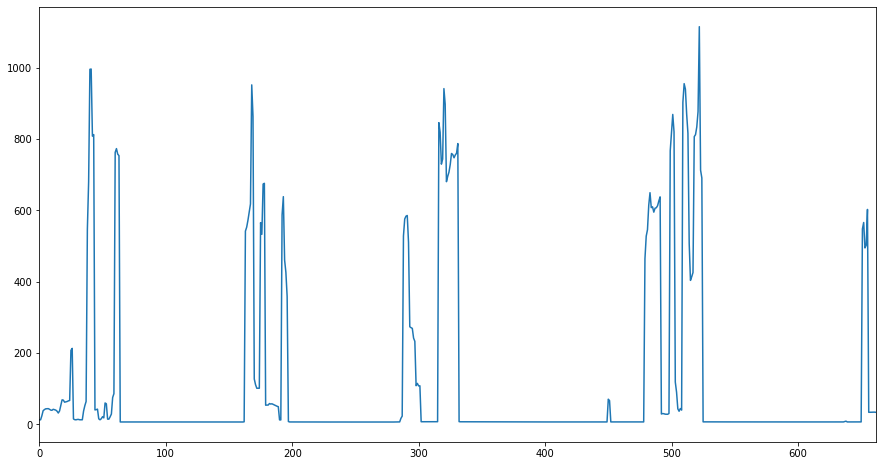

In [38]:
gdf[gdf.q_flag==0].h_li.plot()
# gdf[gdf.q_flag==1].h_li.plot(style='o')

In [39]:
df

,lon,lat,h_li,h_canopy,q_flag,t_dt,strip,coord
0,-136.242355,58.526485,13.293677,29.896385,1,2019-05-22 02:23:49.550,gt1l,POINT (-136.2423553466797 58.52648544311523)
1,-136.242538,58.525589,13.127890,27.753473,0,2019-05-22 02:23:49.564,gt1l,POINT (-136.2425384521484 58.52558898925781)
4,-136.243057,58.522907,18.209900,32.173889,1,2019-05-22 02:23:49.607,gt1l,POINT (-136.2430572509766 58.52290725708008)
5,-136.243240,58.522015,19.664680,33.568680,1,2019-05-22 02:23:49.621,gt1l,POINT (-136.2432403564453 58.52201461791992)
6,-136.243408,58.521118,19.194439,26.773607,1,2019-05-22 02:23:49.635,gt1l,POINT (-136.243408203125 58.5211181640625)
...,...,...,...,...,...,...,...,...
451,-136.355972,58.523464,34.096256,15.481396,0,2019-05-22 02:23:50.002,gt3r,POINT (-136.3559722900391 58.52346420288086)
456,-136.356827,58.518993,34.435921,17.310745,0,2019-05-22 02:23:50.072,gt3r,POINT (-136.3568267822266 58.51899337768555)
465,-136.359741,58.503792,29.741081,29.001234,1,2019-05-22 02:23:50.312,gt3r,POINT (-136.3597412109375 58.50379180908203)
467,-136.360077,58.502003,32.249798,28.793154,1,2019-05-22 02:23:50.340,gt3r,POINT (-136.3600769042969 58.50200271606445)


In [40]:
# 2. Convert to Geopandas
# df['coord'] = df[['lon', 'lat']].apply(lambda x: Point(x), axis=1)
gdf = gpd.GeoDataFrame(df[['t_dt','h_li','strip', 'q_flag','coord']], geometry='coord')
gdf.crs = {'init': 'epsg:4326'} #not yet verified or checked with what ICESAT-2 metadata provides


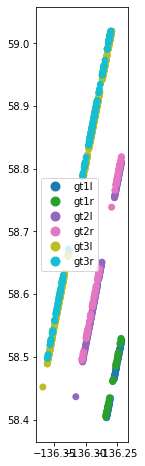

In [41]:
# js = gdf.to_json()
gdf.plot(column='strip', legend=True);